In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
ax = rc("font", family="serif", size=11)

In [6]:
N = 360
C = 5
alpha = 10
beta = 0.1

t = np.linspace(0, np.pi*C, N)
frequency = 20
omega = frequency/(2*np.pi)


def sine(t,alpha,freq):
    return alpha*np.cos(omega*t)
def expn(t,beta):
    return np.exp(-2 * beta * t)

decay = sine(t,alpha,omega) * expn(t,beta)

f_sg = 1
f_true = np.random.randn(N) * f_sg + decay
f_obs_sg = np.ones(N) * 2
f_obs = f_true + np.random.randn(N) * f_obs_sg

data = f_obs

y = sin(wt - phi)

Let's add some noise to the data.

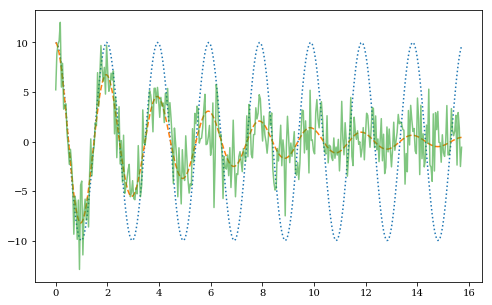

In [7]:
plt.figure(1, figsize=(8,5))
plt.plot(t, sine(t,alpha), ':', t, decay, '--')
plt.plot(t, f_obs, alpha=0.6)
plt.show()

Equation given in Broomhall paper, referenced from Houdek 2008, for second frequency differences $\Delta_2$ is
\begin{equation*}
\Delta_2 \omega_{n,l} = A\omega_{n,l} e^{-2b^2\omega_{n,l}^2} \cos \left[2\left(\tau_{\textrm{He II}}\omega_{n,l}+d\right)\right]+K
\end{equation*}

We shall consider a simplified relation of the form

$$ \alpha\cos(\omega t) e^{-2\beta^2\omega^2} $$ 

In [39]:
code = '''
functions {
    real sine(real freq, real alpha, real t){
        return alpha * sin(freq*t);
    }
    real expn(real freq, real beta){
        return exp(-2 * beta * freq);
    }
}
data {
    int N;
    real t[N];
    real beta;
    real f_unc[N];
}
parameters {
    real<lower = 0> freq;
    real ln_height;

}
transformed parameters {
    real height;
    height = exp(ln_height);
}
model {

    real mod[N];
    for (i in 1:N){
        mod[i] = sine(freq, height, t[i]) * expn(t[i], beta);
    }
    mod ~ N(freq,f_unc);
    freq ~ normal(20.0, 2.0);
    height ~ normal(10.0, 0.3);
    f_unc ~ lognormal(2.0, 1.0);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

ValueError: Failed to parse Stan model 'anon_model_f366fa3d92970f64c09bd98632863fe3'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

Probability function must end in _lpdf or _lpmf. Found distribution family = N with no corresponding probability function N_lpdf, N_lpmf, or N_log
  error in 'unknown file name' at line 31, column 25
  -------------------------------------------------
    29:         mod[i] = sine(freq, height, t[i]) * expn(t[i], beta);
    30:     }
    31:     mod ~ N(freq,f_unc);
                                ^
    32:     freq ~ normal(20.0, 2.0);
  -------------------------------------------------



In [20]:
stan_data = {'N': len(t),
             'f': t, 
             'freq': data}
start = {'freq': 5.0}
nchains = 4
fit = sm.sampling(data=stan_data, iter=1000, chains=nchains, init=[start for n in range(nchains)])

In [21]:
print(fit)

Inference for Stan model: anon_model_830a0db098cefb5951d02f1b236fd0ba.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
freq       20.11    0.05    2.0  16.17  18.77  20.04  21.47  23.95   1378    1.0
ln_height   10.0  7.0e-3   0.31   9.41   9.79   10.0  10.21  10.59   1894    1.0
height     2.3e4  166.29 7205.6  1.2e4  1.8e4  2.2e4  2.7e4  4.0e4   1878    1.0
lp__        1.97    0.04   1.02  -0.67   1.56   2.28   2.71   2.98    778    1.0

Samples were drawn using NUTS at Sun Nov 11 10:48:57 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


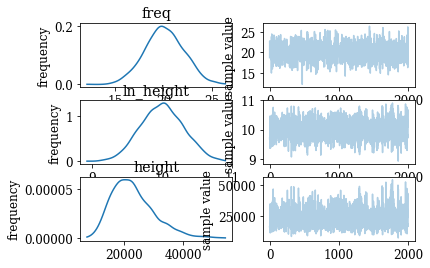

In [22]:
fit.plot()
plt.show()

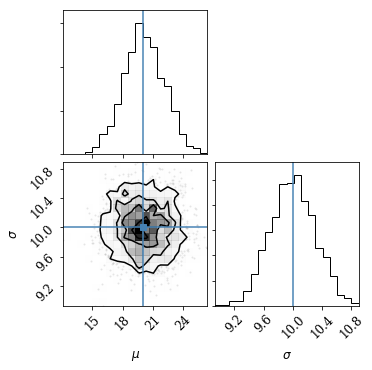

In [23]:
import corner
rc("font", family="serif", size=12)
data = np.vstack([fit['freq'], fit['ln_height']]).T
corner.corner(data, labels=[r'$\mu$', r'$\sigma$'], truths=[20, alpha])
plt.show()